In [1]:
import os
import pandas as pd
import xarray as xr
import geopandas as gpd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure
from shapely.geometry.polygon import Polygon


In [2]:
path_rap = "/glade/p/cisl/aiml/conv_risk_intel/rap_ncei_nc/"
path_save = "/glade/p/cisl/aiml/jtti_tornado/rap_contours/"


In [3]:
def getDatesWithData(path_data):
    directoryList = []
    
    directoryPotential = [x[0] for x in os.walk(path_data)][1:]
    directoryPotential.sort()

    for directory in directoryPotential:
        if len([f for f in os.listdir(directory) if f.endswith('.nc')])>0:
            directoryList.append(directory)

    return directoryList


In [4]:
dates = [x[-8:] for x in getDatesWithData(path_rap)]

date = '20150629'
hour = 12
ds = xr.open_dataset(os.path.join(path_rap, date, f"rap_130_{date}_{hour}00_000.nc"))
lons = ds.longitude.values - 360
lats = ds.latitude.values


In [ ]:
for date in tqdm(dates):
    df = pd.DataFrame()
    for f in [f for f in os.listdir(os.path.join(path_rap, date)) if f.endswith('.nc')]:
        ds = xr.open_dataset(os.path.join(path_rap, date, f))
        hour = f[-11:-9]
        try:
            sbcape = ds.sel(press=1000).to_dataframe()['SBCAPE'].unstack('y').values
        except Exception as e:
            print('--', f, e)
            continue
        for intensity in [1e-12,1000,2000,3000,4000,5000]:
            contours = measure.find_contours(sbcape, intensity)
            for i,contour in enumerate(contours):
                if contour.shape[0] < 3:
                    continue
                else:
                    contour = np.round(contour).astype(int)
                    lons_contour = lons[contour[:, 1:2], contour[:, 0:1]]
                    lats_contour = lats[contour[:, 1:2], contour[:, 0:1]]
                    contour = np.hstack((lons_contour, lats_contour))
                    contour_dict = {"intensity": intensity, "date":date, "hour":hour, "polygon": Polygon(contour)}
                    df = df.append(contour_dict, ignore_index=True)
    gdf = gpd.GeoDataFrame(df, geometry="polygon")
    gdf.to_file(os.path.join(path_save, f'{date}.geojson'), driver='GeoJSON')  


  8%|▊         | 380/4596 [1:15:55<48:55:30, 41.78s/it]

In [17]:
lons - 360

array([[-126.138     , -126.01580486, -125.8935584 , ...,  -69.28642385,
         -69.16217783,  -69.03797574],
       [-126.16658922, -126.04428986, -125.92193904, ...,  -69.26254589,
         -69.13819014,  -69.01387842],
       [-126.19523006, -126.0728263 , -125.95037096, ...,  -69.23862408,
         -69.1141584 ,  -68.98973688],
       ...,
       [-139.7400936 , -139.57107524, -139.40191299, ...,  -57.83016251,
         -57.65529493,  -57.48055476],
       [-139.79803535, -139.62883072, -139.45948169, ...,  -57.78089952,
         -57.6058241 ,  -57.43087657],
       [-139.85612184, -139.68673061, -139.51719445, ...,  -57.73150908,
         -57.55622538,  -57.38107005]])

In [18]:
lats

array([[16.281     , 16.30836614, 16.33562845, ..., 17.38598091,
        17.363161  , 17.34023363],
       [16.39828505, 16.42568412, 16.45297923, ..., 17.50458529,
        17.48173835, 17.45878381],
       [16.51559943, 16.54303139, 16.57035924, ..., 17.62321703,
        17.60034309, 17.57736144],
       ...,
       [53.97394127, 54.00790887, 54.04173934, ..., 55.33884573,
        55.31079595, 55.2826082 ],
       [54.07324369, 54.10721488, 54.14104889, ..., 55.43826705,
        55.41021535, 55.38202566],
       [54.17241813, 54.20639281, 54.24023027, ..., 55.53755643,
        55.5095029 , 55.48131134]])

In [ ]:
# separate geojson from sounding data
# {
#   "type": "Feature",
#   "geometry": {
#     "type": "Point",
#     "coordinates": [125.6, 10.1]
#   },
#   "properties": {
#     "name": "Dinagat Islands"
#   }
# }

# each contour would be a feature with its own geometry, property = intensity
# datetime
# translate row/col values to lat-lon grid
# save example datafile first
# may try NCAR_500 or HRRR data next
# fill holes = True
# dilation


In [ ]:
sbcape = ds.sel(press=1000).to_dataframe()['SBCAPE'].unstack('y').values
print(sbcape.min())
print(sbcape.max())


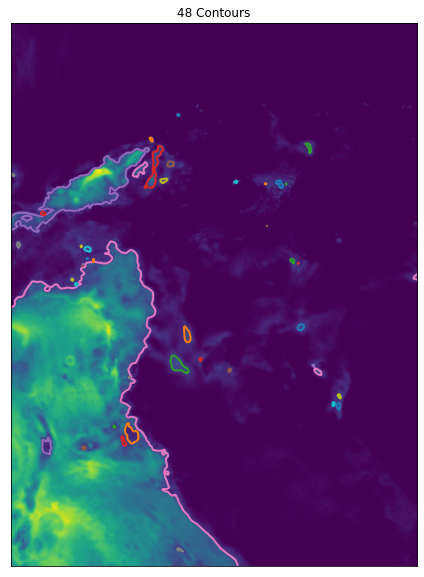

450.0 75.44554455445545 336.0 0.0


In [13]:
contours = measure.find_contours(sbcape, 1000)

fig, ax = plt.subplots(figsize=(8,10))
ax.imshow(sbcape)
max_contour_x = 0
min_contour_x = 1000
max_contour_y = 0
min_contour_y = 1000
for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)
    max_contour_x = max(max_contour_x, max(contour[:, 0]))
    max_contour_y = max(max_contour_y, max(contour[:, 1]))
    min_contour_x = min(min_contour_x, min(contour[:, 0]))
    min_contour_y = min(min_contour_y, min(contour[:, 1]))
ax.set_title(f'{len(contours)} Contours')
ax.set_xticks([])
ax.set_yticks([])
plt.show()
print(max_contour_x, min_contour_x, max_contour_y, min_contour_y)


In [81]:
df = pd.DataFrame()
for intensity in [0,1000,2000,3000,4000,5000]:
    contours = measure.find_contours(sbcape, intensity)
    for i,contour in enumerate(contours):
        if contour.shape[0] < 3:
            print("too small")
            continue
        else:
            contour = np.round(contour).astype(int)
            lons_contour = lons[contour[:, 1], contour[:, 0]]
            lats_contour = lats[contour[:, 1], contour[:, 0]]
            contour = np.hstack((lons_c, lats_c))
            contour_dict = {"intensity": intensity, "date":date, "hour":hour, "polygon": Polygon(contour)}
            df = df.append(contour_dict, ignore_index=True)
gdf = gpd.GeoDataFrame(df, geometry="polygon")
gdf.to_file(os.path.join(path_save, f'{date}.geojson'), driver='GeoJSON')  


too small
too small
too small
too small


In [66]:
contour

array([[411.28571429,  17.        ],
       [411.        ,  16.66666667],
       [410.33333333,  16.        ],
       [410.        ,  15.88888889],
       [409.        ,  16.        ],
       [408.        ,  16.875     ],
       [407.94444444,  17.        ],
       [407.57142857,  18.        ],
       [408.        ,  18.6       ],
       [409.        ,  18.33333333],
       [410.        ,  18.55555556],
       [411.        ,  18.        ],
       [411.28571429,  17.        ]])

In [63]:
contour_rounded = np.round(contour).astype(int)

In [71]:
lons_c = lons[contour_rounded[:, 1:2], contour_rounded[:, 0:1]]
lons_c

array([[286.42793021],
       [286.42793021],
       [286.27997202],
       [286.27997202],
       [286.15231296],
       [286.04460127],
       [286.04460127],
       [286.0646242 ],
       [286.08468496],
       [286.19255616],
       [286.34074641],
       [286.44830573],
       [286.42793021]])

In [72]:
lats_c = lats[contour_rounded[:, 1:2], contour_rounded[:, 0:1]]
lats_c

array([[20.18893338],
       [20.18893338],
       [20.08809855],
       [20.08809855],
       [20.10701437],
       [20.24574416],
       [20.24574416],
       [20.36568824],
       [20.48564952],
       [20.34684286],
       [20.44780417],
       [20.30881421],
       [20.18893338]])

In [80]:
np.hstack((lons_c, lats_c))

array([[286.42793021,  20.18893338],
       [286.42793021,  20.18893338],
       [286.27997202,  20.08809855],
       [286.27997202,  20.08809855],
       [286.15231296,  20.10701437],
       [286.04460127,  20.24574416],
       [286.04460127,  20.24574416],
       [286.0646242 ,  20.36568824],
       [286.08468496,  20.48564952],
       [286.19255616,  20.34684286],
       [286.34074641,  20.44780417],
       [286.44830573,  20.30881421],
       [286.42793021,  20.18893338]])

In [25]:
lons_contour = []
lats_contour = []
for y in contour[:, 1]:
    if y.is_integer():
        lons_contour.append(lons[int(y)])
    else:
        print("False")

142.0
False
141.0
140.0
139.0
138.0
False
False
138.0
139.0
140.0
141.0
142.0
